In [172]:
import pandas as pd
import numpy as np

#import torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams


import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix


from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf

## Importing Data

In [85]:
dataset = pd.read_csv('day1_dataset_10min.csv')

In [86]:
dataset= dataset.drop(['Unnamed: 0'], axis=1)

In [88]:
dataset

,Datetime_updated_seconds,Price_USD,Price_Crypto,densities,vertex_count,edge_count,volume,collection,blacklisted,whitelisted
0,2020-12-02 12:20:00,0.040150,1.0,1.0,2.0,1.0,1.0,12345rainbow,1,0
1,2020-12-02 12:30:00,0.040150,1.0,1.0,2.0,1.0,0.0,12345rainbow,1,0
2,2020-12-02 12:40:00,0.040150,1.0,1.0,2.0,1.0,0.0,12345rainbow,1,0
3,2020-12-02 12:50:00,0.040150,1.0,1.0,2.0,1.0,0.0,12345rainbow,1,0
4,2020-12-02 13:00:00,0.040150,1.0,1.0,2.0,1.0,0.0,12345rainbow,1,0
...,...,...,...,...,...,...,...,...,...,...
143275,2020-10-12 21:20:00,0.720015,23.0,1.0,2.0,1.0,0.0,zombieartist,0,1
143276,2020-10-12 21:30:00,0.720015,23.0,1.0,2.0,1.0,0.0,zombieartist,0,1
143277,2020-10-12 21:40:00,0.720015,23.0,1.0,2.0,1.0,0.0,zombieartist,0,1
143278,2020-10-12 21:50:00,0.720015,23.0,1.0,2.0,1.0,0.0,zombieartist,0,1


In [89]:
columns = ['Datetime_updated_seconds','Price_USD','Price_Crypto','volume','densities', 'vertex_count','edge_count','collection']
X_train = dataset[columns]
y_train = dataset[['blacklisted','collection']]

In [90]:
X_train

,Datetime_updated_seconds,Price_USD,Price_Crypto,volume,densities,vertex_count,edge_count,collection
0,2020-12-02 12:20:00,0.040150,1.0,1.0,1.0,2.0,1.0,12345rainbow
1,2020-12-02 12:30:00,0.040150,1.0,0.0,1.0,2.0,1.0,12345rainbow
2,2020-12-02 12:40:00,0.040150,1.0,0.0,1.0,2.0,1.0,12345rainbow
3,2020-12-02 12:50:00,0.040150,1.0,0.0,1.0,2.0,1.0,12345rainbow
4,2020-12-02 13:00:00,0.040150,1.0,0.0,1.0,2.0,1.0,12345rainbow
...,...,...,...,...,...,...,...,...
143275,2020-10-12 21:20:00,0.720015,23.0,0.0,1.0,2.0,1.0,zombieartist
143276,2020-10-12 21:30:00,0.720015,23.0,0.0,1.0,2.0,1.0,zombieartist
143277,2020-10-12 21:40:00,0.720015,23.0,0.0,1.0,2.0,1.0,zombieartist
143278,2020-10-12 21:50:00,0.720015,23.0,0.0,1.0,2.0,1.0,zombieartist


In [91]:
y_train

,blacklisted,collection
0,1,12345rainbow
1,1,12345rainbow
2,1,12345rainbow
3,1,12345rainbow
4,1,12345rainbow
...,...,...
143275,0,zombieartist
143276,0,zombieartist
143277,0,zombieartist
143278,0,zombieartist


In [31]:
len(y_train)

143280

In [30]:
(X_train.collection.value_counts() == 144).sum()

995

In [105]:
daily_sequence = []
feature_columns=['Price_USD','Price_Crypto','volume','densities', 'vertex_count','edge_count']
print(feature_columns)
for collection, group in X_train.groupby("collection"):
    features = group[group.columns.intersection(feature_columns)]
    blacklist = y_train[y_train.collection == collection].iloc[0].blacklisted
    daily_sequence.append((features, blacklist))

['Price_USD', 'Price_Crypto', 'volume', 'densities', 'vertex_count', 'edge_count']


In [107]:
train_sequences, test_sequences = train_test_split(daily_sequence, test_size = 0.2)

In [108]:
len(train_sequences), len(test_sequences)

(796, 199)

In [53]:
class DailyData(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, blacklisted = self.sequences[idx]
        return dict(sequence = torch.Tensor(sequence.to_numpy()), label = torch.tensor(blacklisted).long())

In [57]:
pl.seed_everything(7)
class CollectionDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = DailyData(self.train_sequences)
        self.test_dataset = DailyData(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size = self.batch_Size,
            shuffle = True,
            num_workers = cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffl=False,
            num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size = self.batch_Size,
            shuffle = True,
            num_workers = cpu_count()
        )
    

Global seed set to 7


In [58]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module =  CollectionDataMododule(train_sequences, test_sequences, BATCH_SIZE)

## Model

In [ ]:
# class CollectionModel(nn.Module):
#     def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3)
#         super().__init__()
        
#         self.conv1d = nn.Conv1d(n_features, n_hidden, n_layers,)

In [109]:
[sequence[0] for sequence in train_sequences]

[       Price_USD  Price_Crypto  volume  densities  vertex_count  edge_count
 58752    0.56700           2.0     1.0   1.000000           2.0         1.0
 58753    0.56700           2.0     0.0   1.000000           2.0         1.0
 58754    0.56700           2.0     0.0   1.000000           2.0         1.0
 58755    0.56700           2.0     0.0   1.000000           2.0         1.0
 58756    0.56700           2.0     0.0   1.000000           2.0         1.0
 ...          ...           ...     ...        ...           ...         ...
 58891    0.53865           1.9     0.0   0.666667           3.0         2.0
 58892    0.53865           1.9     0.0   0.666667           3.0         2.0
 58893    0.53865           1.9     0.0   0.666667           3.0         2.0
 58894    0.53865           1.9     0.0   0.666667           3.0         2.0
 58895    0.53865           1.9     0.0   0.666667           3.0         2.0
 
 [144 rows x 6 columns],
        Price_USD  Price_Crypto  volume  densitie

In [68]:
[sequence[1] for sequence in train_sequences]

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,


In [61]:
X_train.shape[0]

143280

(144, 8)

In [110]:
NUM_FILTERS = 10
K_SIZE = 4
MODEL_SHAPE = train_sequences[0][0].shape

In [111]:
MODEL_SHAPE

(144, 6)

In [164]:
def get_base_model(shape, k_size = K_SIZE, num_filters = NUM_FILTERS):
    print(shape)
    input_seq = Input(shape=shape)
    nb_filters = num_filters
    convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    compressed = Dense(50, activation="relu")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

In [165]:
def main_model(shape):
    print(shape)
    input_origseq = Input(shape=shape)
    base_model = get_base_model(shape)
    out = Dense(1, activation='sigmoid')(base_model.output)
    model = Model(inputs=base_model.input, outputs=out)
    return model

In [256]:
def run_model(x_train, y_train, x_test, y_test):
    es = keras.callbacks.EarlyStopping(min_delta=0.00001, patience=10)
    #data_set = tf.data.Dataset.from_tensor_slices(  (x_train ,y_train) )
    model = main_model(MODEL_SHAPE)
    model.compile(loss='binary_crossentropy', # categorical_crossentropy
                          optimizer='adam', #sgd, nadam, adam, rmsprop
                          metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), ])
    model_hist = model.fit(x_train, y_train,
                               validation_data=(x_test, y_test),
                               batch_size=20, epochs=1000, 
                           callbacks=[es]
                          )
    return model_hist, model

In [187]:
x_train = [sequence[0].to_numpy() for sequence in train_sequences]
y_train = [sequence[1] for sequence in train_sequences]
x_test = [sequence[0].to_numpy() for sequence in test_sequences]
y_test = [sequence[1] for sequence in test_sequences]

In [251]:
sum(y_test)

58

In [188]:
all_x_test = np.stack(x_test)

In [190]:
all_x_train = np.stack(x_train)

In [242]:
all_x_train.reshape(796,144,6)

array([[[5.67000000e-01, 2.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         2.00000000e+00, 1.00000000e+00],
        [5.67000000e-01, 2.00000000e+00, 0.00000000e+00, 1.00000000e+00,
         2.00000000e+00, 1.00000000e+00],
        [5.67000000e-01, 2.00000000e+00, 0.00000000e+00, 1.00000000e+00,
         2.00000000e+00, 1.00000000e+00],
        ...,
        [5.38650000e-01, 1.90000000e+00, 0.00000000e+00, 6.66666667e-01,
         3.00000000e+00, 2.00000000e+00],
        [5.38650000e-01, 1.90000000e+00, 0.00000000e+00, 6.66666667e-01,
         3.00000000e+00, 2.00000000e+00],
        [5.38650000e-01, 1.90000000e+00, 0.00000000e+00, 6.66666667e-01,
         3.00000000e+00, 2.00000000e+00]],

       [[8.72500000e-01, 5.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         2.00000000e+00, 1.00000000e+00],
        [8.72500000e-01, 5.00000000e+00, 0.00000000e+00, 1.00000000e+00,
         2.00000000e+00, 1.00000000e+00],
        [8.72500000e-01, 5.00000000e+00, 0.00000000e+00, 1.000000

In [243]:
all_x_test.reshape(199,144,6)

array([[[1.64250000e-03, 1.00000000e-02, 1.00000000e+01, 4.03975469e-01,
         6.50000000e+00, 5.50000000e+00],
        [1.64250000e-03, 1.00000000e-02, 0.00000000e+00, 4.03975469e-01,
         6.50000000e+00, 5.50000000e+00],
        [1.64250000e-03, 1.00000000e-02, 0.00000000e+00, 4.03975469e-01,
         6.50000000e+00, 5.50000000e+00],
        ...,
        [1.04700000e-02, 6.00000000e-02, 0.00000000e+00, 6.45161290e-02,
         3.20000000e+01, 3.20000000e+01],
        [1.04700000e-02, 6.00000000e-02, 0.00000000e+00, 6.45161290e-02,
         3.20000000e+01, 3.20000000e+01],
        [1.04700000e-02, 6.00000000e-02, 0.00000000e+00, 6.45161290e-02,
         3.20000000e+01, 3.20000000e+01]],

       [[1.15925000e+01, 5.00000000e+01, 1.00000000e+00, 1.00000000e+00,
         2.00000000e+00, 1.00000000e+00],
        [2.88653250e+01, 1.24500000e+02, 2.00000000e+00, 5.83333333e-01,
         3.50000000e+00, 2.50000000e+00],
        [2.88653250e+01, 1.24500000e+02, 0.00000000e+00, 5.833333

In [257]:
model_hist, model = run_model(all_x_train,  np.array(y_train), all_x_test,  np.array(y_test))

(144, 6)
(144, 6)
Epoch 1/1000
40/40 [==============================] - 1s 11ms/step - loss: 5.1957 - binary_accuracy: 0.6294 - precision: 0.3243 - recall: 0.3318 - val_loss: 3.0449 - val_binary_accuracy: 0.7085 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 3.0708 - binary_accuracy: 0.6935 - precision: 0.3043 - recall: 0.0968 - val_loss: 3.5173 - val_binary_accuracy: 0.7085 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
40/40 [==============================] - 0s 4ms/step - loss: 2.8984 - binary_accuracy: 0.6809 - precision: 0.2597 - recall: 0.0922 - val_loss: 3.0559 - val_binary_accuracy: 0.7085 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
40/40 [==============================] - 0s 3ms/step - loss: 2.6856 - binary_accuracy: 0.6872 - precision: 0.3519 - recall: 0.1751 - val_loss: 2.6480 - val_binary_accuracy: 0.7085 - val_precision: 0.0000e+00 - val_recall: 0.0000e+

Epoch 35/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.6685 - binary_accuracy: 0.7211 - precision: 0.4419 - recall: 0.0876 - val_loss: 0.8722 - val_binary_accuracy: 0.6985 - val_precision: 0.2500 - val_recall: 0.0172
Epoch 36/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.6925 - binary_accuracy: 0.7060 - precision: 0.4066 - recall: 0.1705 - val_loss: 0.8104 - val_binary_accuracy: 0.6834 - val_precision: 0.3333 - val_recall: 0.0862
Epoch 37/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.6524 - binary_accuracy: 0.7060 - precision: 0.3867 - recall: 0.1336 - val_loss: 0.7685 - val_binary_accuracy: 0.6834 - val_precision: 0.3333 - val_recall: 0.0862
Epoch 38/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.6059 - binary_accuracy: 0.7198 - precision: 0.4681 - recall: 0.2028 - val_loss: 0.7627 - val_binary_accuracy: 0.6784 - val_precision: 0.2857 - val_recall: 0.0690
Epoch 39/1000
40/40 [=======================

In [245]:
prediction = model.predict(all_x_test)

In [247]:
prediction[prediction <=0.5] = 0
prediction[prediction >0.5] = 1

In [255]:
sum([pred[0] for pred in prediction.tolist()])

15.0

In [215]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_binary_accuracy'] + history.history['binary_accuracy']),
                        max(history.history['val_binary_accuracy'] + history.history['binary_accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['binary_accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['binary_accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_binary_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

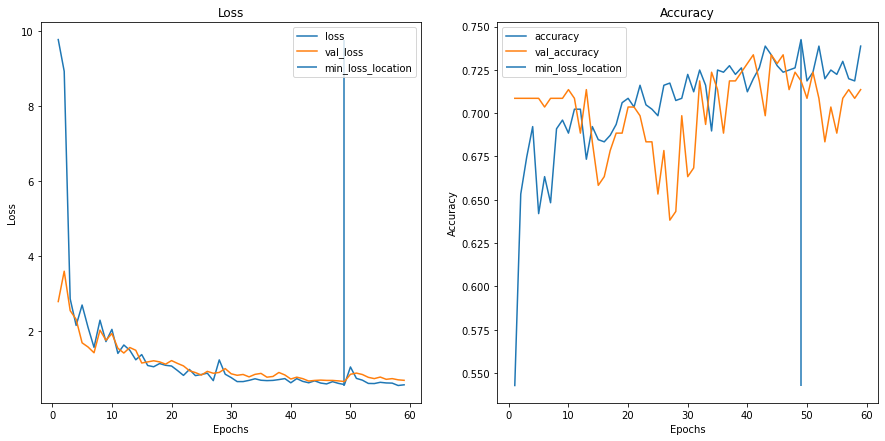

In [230]:
plot_training_curves(history=model_hist)